In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from dataloader import dataset
from unet import UNet
import os
import time

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Generate training, validation and test datasets
# random split
train_set_size = int(len(dataset)*0.6)
valid_set_size = int(len(dataset)*0.2)
test_set_size = len(dataset)-train_set_size-valid_set_size
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [train_set_size, valid_set_size, test_set_size])

# start to load from customized DataSet object
# bring batch size, iterations and epochs together
batch_size = 5
train_loader = DataLoader(train_set,batch_size,shuffle=False,drop_last=True,pin_memory=False)
valid_loader = DataLoader(valid_set,batch_size,shuffle=False,drop_last=True,pin_memory=False)
test_loader = DataLoader(test_set,batch_size,shuffle=False,drop_last=True,pin_memory=False)

In [ ]:
print(train_set_size, valid_set_size, test_set_size)

In [17]:
for x,y in train_set:
    print(x.size())
    print(y.size())
    break

torch.Size([1024, 1024, 3])
torch.Size([512, 512, 3])


In [3]:
model = UNet(in_channels=3,
            out_channels=3,
            n_blocks=4,
            start_filters=32,
            activation='relu',
            normalization='batch',
            conv_mode='same',
            dim=2)
# x = torch.randn(size=(3, 3, 1024,1024), dtype=torch.float32)
# with torch.no_grad():
#     out = model(x)
    
# print(f'Out: {out.shape}')

# outpushape: [batch, channel, H, W]
# inputshape: [batch, channel, 1024, 1024]

In [ ]:
# x = torch.randn(size=(3, 3, 1024,1024), dtype=torch.float32)

print(x.view(x.shape[0]*x.shape[2]*x.shape[3], x.shape[1]).shape)

In [ ]:
x = torch.randn(size=(5, 3, 1024,1024), dtype=torch.float32)
x = x.reshape(5*3*1024, 1024)
print(x.shape)

In [4]:
batch_size = 5
n_iters = int(train_set_size / batch_size)
epochs = 10
lr = 0.001
iterations = epochs * n_iters
step_size = 2*n_iters
model_name ="{}epochs_lr{}_step{}".format(epochs, lr, step_size)
save_PATH = './model_name'
if not os.path.exists(save_PATH):
    os.mkdir(save_PATH)

In [5]:
model = model.float()
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr)

In [6]:
def acc_fn(outputs, y):
    num_samples = len(y)
    equality_matrix = torch.eq(outputs, y)
    num_corr_pred = equality_matrix.sum()
    acc = num_corr_pred/num_samples
    return acc    

In [21]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    # model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                # x = x.cuda()
                # y = y.cuda()
                x = torch.permute(x, (0, 3, 2, 1))
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x) 
                    outputs = torch.permute(outputs, (0,2,3,1)) #true y: [512,512,3]  outputs: [batch,512,512,3]
                    batch, h, w, channel = outputs.shape
                    outputs_loss = outputs.reshape(batch, h*w, channel)
                    y = y.reshape(batch, h*w, channel)
                    # outputs = torch.permute(outputs, (0, 2, 3, 1)).contiguous().view(-1, inp.size(1))
                    
                    # y = torch.permute(y, (0,3,2,1))
                    y = y.to(torch.float64)
                    outputs = outputs.to(torch.float64)
                    # print(outputs.shape)
                    # print(y.shape)
                    
                    # print('outputs', outputs, outputs.shape)
                    plt.imshow(outputs[0].detach().numpy())
                    plt.imshow(outputs[1].detach().numpy())
                    plt.imshow(outputs[2].detach().numpy())
                    plt.imshow(outputs[3].detach().numpy())
                    plt.imshow(outputs[4].detach().numpy())
                    
                    loss = loss_fn(outputs_loss, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs_loss, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 10 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            
            return train_loss, valid_loss 

Epoch 0/9
----------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

KeyboardInterrupt: 

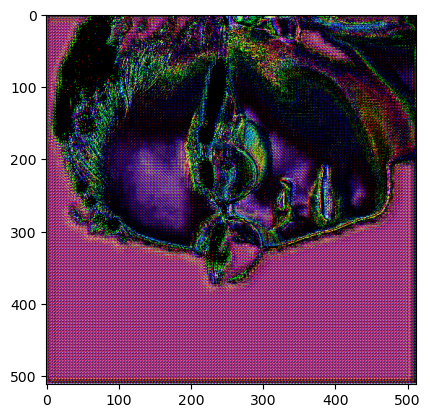

In [22]:
train_loss, valid_loss = train(model, train_loader, valid_loader, loss_fn, opt, acc_fn, epochs)